
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/52_Genetic_Algorithms_Evolution.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 🧬 Algorytmy Genetyczne: Ewolucja w Kodzie

Kiedy Gradient Descent nie działa (bo problem jest dyskretny lub poszarpany), wzywamy na pomoc Karola Darwina.

Rozwiążemy **Problem Plecakowy**:
*   Mamy listę przedmiotów (Złoto, Laptop, Kamień...).
*   Każdy ma **Wagę** i **Wartość**.
*   Plecak ma limit wagowy.

**Cel:** Wybrać taki zestaw przedmiotów (0/1), żeby wartość była maksymalna, a waga nie przekroczyła limitu.

Zrobimy to bez matematycznych wzorów, używając czystej symulacji ewolucji.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

# 1. DEFINIUJEMY PROBLEM
# Przedmioty: [Waga (kg), Wartość ($)]
items = [
    [10, 60],  # Przedmiot 0 (Ciężki, średnio drogi)
    [20, 100], # Przedmiot 1
    [30, 120], # Przedmiot 2
    [5,  100], # Przedmiot 3 (Lekki, drogi - Super!)
    [15, 70],  # ...
    [40, 200],
    [2,  20],
    [8,  40],
    [12, 50],
    [25, 150]
]
items = np.array(items)

MAX_WEIGHT = 50 # Maksymalny udźwig plecaka

print(f"Liczba przedmiotów: {len(items)}")
print(f"Limit wagi: {MAX_WEIGHT} kg")

Liczba przedmiotów: 10
Limit wagi: 50 kg


## Krok 1: DNA i Populacja

Nasze DNA to prosty ciąg zer i jedynek.
*   `[1, 0, 0, 1, ...]` oznacza: "Biorę przedmiot nr 0 i nr 3. Resztę zostawiam".

Stworzymy populację 50 losowych "osobników" (plecaków).

In [2]:
POPULATION_SIZE = 50
DNA_LENGTH = len(items)

# Generujemy losową populację (macierz 50 x 10 zer i jedynek)
population = np.random.randint(0, 2, size=(POPULATION_SIZE, DNA_LENGTH))

print("--- PRZYKŁADOWY OSOBNIK (GENOM) ---")
print(population[0])
print("(1 = zabrać, 0 = zostawić)")

--- PRZYKŁADOWY OSOBNIK (GENOM) ---
[1 0 0 0 1 1 1 0 1 1]
(1 = zabrać, 0 = zostawić)


## Krok 2: Fitness Function (Przystosowanie)

To najważniejsza funkcja. Musi ocenić, jak "dobry" jest dany plecak.
1.  Sumujemy wartości przedmiotów.
2.  Sumujemy wagi.
3.  **Kara:** Jeśli waga > limit, to plecak jest bezużyteczny (wartość = 0 lub kara). Tutaj dla uproszczenia ustawimy Fitness = 0, żeby takie osobniki "wymarły".

In [3]:
def calculate_fitness(population, items, max_weight):
    scores = []
    
    for individual in population:
        # Mnożymy DNA (0/1) przez wartości przedmiotów
        current_weight = np.sum(individual * items[:, 0])
        current_value  = np.sum(individual * items[:, 1])
        
        # Jeśli plecak jest za ciężki -> Fitness = 0 (Śmierć)
        if current_weight > max_weight:
            scores.append(0)
        else:
            scores.append(current_value)
            
    return np.array(scores)

# Testujemy na losowej populacji
fitness_scores = calculate_fitness(population, items, MAX_WEIGHT)
print(f"Najlepszy wynik w losowej populacji: {np.max(fitness_scores)}$")

Najlepszy wynik w losowej populacji: 250$


## Krok 3: Ewolucja (Pętla Życia)

Teraz uruchamiamy machinę Darwina na 100 pokoleń.

W każdym pokoleniu:
1.  **Selekcja:** Losujemy rodziców. Im lepszy wynik (Fitness), tym większa szansa na bycie wybranym.
2.  **Krzyżowanie (Crossover):** Bierzemy połówkę DNA od taty i połówkę od mamy.
3.  **Mutacja:** Z bardzo małą szansą (np. 1%) zmieniamy losowy bit (żeby odkryć nowe możliwości).

In [4]:
GENERATIONS = 100
MUTATION_RATE = 0.05 # 5% szansy na mutację genu

history_best = []

for generation in range(GENERATIONS):
    # 1. OCENA (Fitness)
    fitness = calculate_fitness(population, items, MAX_WEIGHT)
    
    # Zapisujemy najlepszego
    best_score = np.max(fitness)
    history_best.append(best_score)
    
    # Jeśli wszyscy umarli (za ciężkie plecaki), restartujemy losowo
    if best_score == 0:
        population = np.random.randint(0, 2, size=(POPULATION_SIZE, DNA_LENGTH))
        continue

    # 2. SELEKCJA (Ruletka)
    # Prawdopodobieństwo wyboru zależy od wyniku
    probs = fitness / fitness.sum()
    
    # Wybieramy rodziców (z powtórzeniami)
    parents_indices = np.random.choice(np.arange(POPULATION_SIZE), size=POPULATION_SIZE, p=probs)
    parents = population[parents_indices]
    
    # 3. KRZYŻOWANIE (Crossover)
    children = []
    for i in range(0, POPULATION_SIZE, 2):
        parent1 = parents[i]
        parent2 = parents[i+1]
        
        # Punkt przecięcia (gdzie tniemy DNA?)
        cut = np.random.randint(1, DNA_LENGTH-1)
        
        # Dziecko 1: Głowa Taty, Ogon Mamy
        child1 = np.concatenate([parent1[:cut], parent2[cut:]])
        # Dziecko 2: Głowa Mamy, Ogon Taty
        child2 = np.concatenate([parent2[:cut], parent1[cut:]])
        
        children.append(child1)
        children.append(child2)
    
    children = np.array(children)
    
    # 4. MUTACJA
    # Tworzymy maskę losowych zmian (0 lub 1)
    mutation_mask = np.random.random(children.shape) < MUTATION_RATE
    # Odwracamy bity tam, gdzie wypadła mutacja (XOR)
    children = np.logical_xor(children, mutation_mask).astype(int)
    
    # Nowe pokolenie zastępuje stare
    population = children

# WYNIK KOŃCOWY
final_fitness = calculate_fitness(population, items, MAX_WEIGHT)
best_idx = np.argmax(final_fitness)
best_dna = population[best_idx]

print(f"🏆 Koniec ewolucji!")
print(f"Najlepszy wynik: {final_fitness[best_idx]}$")
print(f"Najlepsze DNA: {best_dna}")

🏆 Koniec ewolucji!
Najlepszy wynik: 370$
Najlepsze DNA: [1 0 0 1 0 0 1 1 0 1]


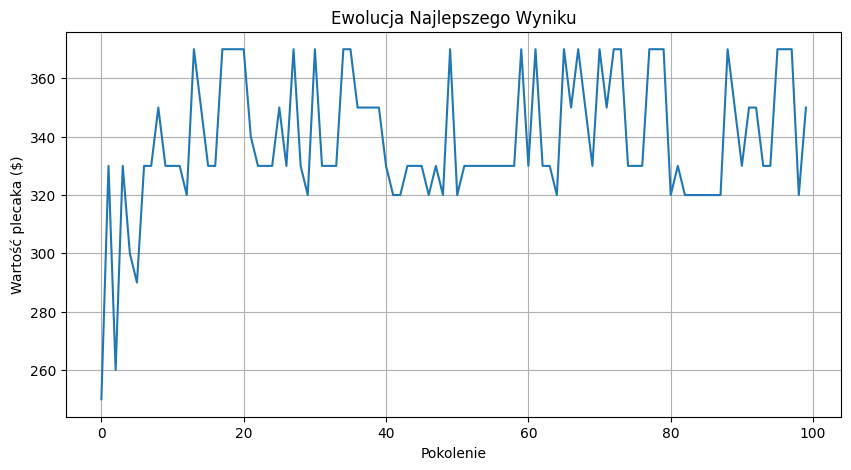

--- ZAWARTOŚĆ ZWYCIĘSKIEGO PLECAKA ---
Przedmiot 0: Waga 10kg, Wartość 60$
Przedmiot 3: Waga 5kg, Wartość 100$
Przedmiot 6: Waga 2kg, Wartość 20$
Przedmiot 7: Waga 8kg, Wartość 40$
Przedmiot 9: Waga 25kg, Wartość 150$
------------------------------
SUMA: Waga 50/50kg, Wartość 370$


In [5]:
# Wizualizacja postępu
plt.figure(figsize=(10, 5))
plt.plot(history_best)
plt.title("Ewolucja Najlepszego Wyniku")
plt.xlabel("Pokolenie")
plt.ylabel("Wartość plecaka ($)")
plt.grid(True)
plt.show()

# Co dokładnie zabraliśmy?
print("--- ZAWARTOŚĆ ZWYCIĘSKIEGO PLECAKA ---")
total_w = 0
total_v = 0
for i, take in enumerate(best_dna):
    if take:
        w, v = items[i]
        print(f"Przedmiot {i}: Waga {w}kg, Wartość {v}$")
        total_w += w
        total_v += v

print("-" * 30)
print(f"SUMA: Waga {total_w}/{MAX_WEIGHT}kg, Wartość {total_v}$")

## 🧠 Podsumowanie: Siła Przypadku

Algorytm genetyczny nie "myśli" i nie liczy pochodnych. On po prostu **zgaduje**, ale robi to w sposób ukierunkowany (selekcja).

**Kiedy stosować?**
1.  Gdy problem jest "nieciągły" (np. nie możesz zabrać 0.5 laptopa).
2.  Gdy funkcja celu jest bardzo skomplikowana (np. projektowanie kształtu skrzydła samolotu pod tunel aerodynamiczny).
3.  Gdy nie zależy nam na idealnym rozwiązaniu (optimum globalne), ale na "wystarczająco dobrym" w krótkim czasie.

W naszym przypadku, po 20-30 pokoleniach, algorytm prawdopodobnie znalazł optymalne lub bliskie optymalnemu upakowanie plecaka.